In [ ]:
from pathlib import Path
from loguru import logger

import cv2
import seaborn as sns
from IPython.display import clear_output
import numpy as np
import numpy.typing as npt
import matplotlib.pyplot as plt
import pyfftw
from scipy.special import erf

from topostats.io import LoadScans
from topostats.filters import Filters
from topostats.plottingfuncs import Colormap

colormap = Colormap()
CMAP = colormap.get_cmap()
VMIN = None
VMAX = None

DATA_DIR = Path("/Users/sylvi/topo_data/perovskite/textured_silicon/")
files = list(DATA_DIR.glob("*"))
logger.info(f"Found {len(files)} files in {DATA_DIR}")
for file in files:
    logger.info(file)

loadscans = LoadScans(files, channel="Height Sensor")
loadscans.get_data()
image_dictionaries = loadscans.img_dict
logger.info(f"Loaded {len(image_dictionaries)} images")

In [ ]:
flattened_images = {}
for filename, topostats_object in image_dictionaries.items():
    filename = Path(filename).name
    logger.info(f"Flattening {filename}")
    filters = Filters(
        image=topostats_object["image_original"],
        filename=filename,
        pixel_to_nm_scaling=topostats_object["pixel_to_nm_scaling"],
        row_alignment_quantile=None,
        threshold_method=None,
        gaussian_size=0.01,
        remove_scars={
            "run": False,
        },
    )
    filters.filter_image()
    flattened_images[filename] = {
        "original_image": topostats_object["image_original"],
        "flattened_image": filters.images["gaussian_filtered"],
        "pixel_to_nm_scaling": topostats_object["pixel_to_nm_scaling"],
    }
clear_output()
logger.info(f"Flattened {len(flattened_images)} images")

In [ ]:
def plot_images(images: list, masks: list, px_to_nms: list, filenames: list, width=3, VMIN=VMIN, VMAX=VMAX, cmap=CMAP):
    num_images = len(images)
    num_rows = num_images // width + 1
    num_images_in_batch = 2
    fig, axes = plt.subplots(num_rows, width * num_images_in_batch, figsize=(width * 8, num_rows * 4))
    for i, (image, mask, p_to_nm, filename) in enumerate(zip(images, masks, px_to_nms, filenames)):
        # Plot image
        im_ax = axes[i // width, i % width * num_images_in_batch]
        im_ax.imshow(image, cmap=CMAP, vmin=VMIN, vmax=VMAX)
        im_ax.set_title(f"{p_to_nm:.3f} p/nm\n{filename}")
        im_ax.axis("off")
        # Plot mask
        mask_ax = axes[i // width, i % width * num_images_in_batch + 1]
        mask_ax.imshow(mask.astype(int))
        mask_ax.axis("off")

    fig.tight_layout()
    plt.show()

In [ ]:
logger.info(f"{flattened_images.keys()}")
plot_images(
    images=[flattened_images[filename]["flattened_image"] for filename in flattened_images.keys()],
    masks=[np.zeros_like(flattened_images[filename]["flattened_image"]) for filename in flattened_images.keys()],
    px_to_nms=[flattened_images[filename]["pixel_to_nm_scaling"] for filename in flattened_images.keys()],
    filenames=[filename for filename in flattened_images.keys()],
)

In [ ]:
# perform a frequency split
image: dict = flattened_images[list(flattened_images.keys())[0]]


def remove_low_frequencies(
    image: npt.NDArray[np.float32],
    pixel_to_nm_scaling: float,
    frequency_threshold: float,
    gaussian_strength: float = 0.0,
    debug: bool = False,
) -> npt.NDArray[np.float32]:

    # Set the zero point to zero
    image -= np.min(image)
    image_size_nm = image.shape[0] * pixel_to_nm_scaling
    if debug:
        logger.info(f"Image size real: {image_size_nm} nm")

    if debug:
        # Plot image
        plt.imshow(image, cmap=CMAP, vmin=VMIN, vmax=VMAX)
        plt.title("Original image")
        plt.show()
        # plot kde of image heights
        sns.kdeplot(image.flatten())
        plt.title(f"Image heights before filtering")
        plt.show()

    # Extend image for periodic boundary conditions
    extended_image = cv2.copyMakeBorder(
        image,
        image.shape[0] // 2,
        image.shape[0] // 2,
        image.shape[1] // 2,
        image.shape[1] // 2,
        cv2.BORDER_REFLECT,
    )

    if debug:
        plt.imshow(extended_image, cmap=CMAP, vmin=VMIN, vmax=VMAX)
        plt.title("Extended image")
        # Draw bounding box around original image
        plt.plot(
            [
                image.shape[1] // 2,
                image.shape[1] // 2,
                image.shape[1] // 2 + image.shape[1],
                image.shape[1] // 2 + image.shape[1],
                image.shape[1] // 2,
            ],
            [
                image.shape[0] // 2,
                image.shape[0] // 2 + image.shape[0],
                image.shape[0] // 2 + image.shape[0],
                image.shape[0] // 2,
                image.shape[0] // 2,
            ],
            color="white",
        )
        plt.show()

    # Remove frequency below 400nm from the image using opencv
    dft = cv2.dft(np.float32(extended_image), flags=cv2.DFT_COMPLEX_OUTPUT)
    # This produces two images, one for the real part and one for the imaginary part
    dft_shift = np.fft.fftshift(dft)  # shift the zero frequency component to the center
    # Create a magnitude spectrum, showing the frequency content of the image with the zero
    # frequency component in the center
    if debug:
        magnitude_spectrum = 20 * np.log(cv2.magnitude(dft_shift[:, :, 0], dft_shift[:, :, 1]))
        plt.imshow(magnitude_spectrum, cmap="viridis")
        plt.show()

    # Create a mask to remove the low frequency content
    rows, cols = extended_image.shape
    crow, ccol = rows // 2, cols // 2
    mask = np.ones((rows, cols, 2), np.float32)
    # create the radius in pixels from the wavelength in nm
    radius = frequency_threshold / pixel_to_nm_scaling
    if debug:
        logger.info(f"Mask radius px: {radius}")

    mask[int(crow - radius) : int(crow + radius), int(ccol - radius) : int(ccol + radius)] = 0.0
    # invert the mask
    mask = 1.0 - mask

    if gaussian_strength > 0:
        # Blur the mask
        mask = cv2.GaussianBlur(mask, (0, 0), gaussian_strength * radius)

    # apply the mask
    fshift = dft_shift * mask

    if debug:
        # Show the mask
        magnitude_spectrum = 20 * np.log(cv2.magnitude(fshift[:, :, 0], fshift[:, :, 1]))
        plt.imshow(magnitude_spectrum, cmap="viridis")
        plt.show()

    # inverse the shift
    f_ishift = np.fft.ifftshift(fshift)
    # inverse the dft
    img_back = cv2.idft(f_ishift)
    img_back = cv2.magnitude(img_back[:, :, 0], img_back[:, :, 1])

    # Normalize the image
    img_back /= rows * cols

    # Crop the image back to the original size
    img_back = img_back[
        image.shape[0] // 2 : -image.shape[0] // 2,
        image.shape[1] // 2 : -image.shape[1] // 2,
    ]

    if debug:
        plt.imshow(img_back, cmap="viridis")
        plt.show()

    logger.info(
        f"Image stats:\nmin: {np.min(img_back)}\n max: {np.max(img_back)}\n mean: {np.mean(img_back)}\n median: {np.median(img_back)}"
    )
    if debug:
        # plot kde of image heights
        sns.kdeplot(img_back.flatten())
        plt.title(f"Image heights after filtering")
        plt.show()

    # put a cap on the 90th and 10th percentile
    # img_back[img_back > np.percentile(img_back, 90)] = np.percentile(img_back, 90)
    # img_back[img_back < np.percentile(img_back, 10)] = np.percentile(img_back, 10)
    if debug:
        plt.imshow(img_back, cmap=CMAP, vmin=VMIN, vmax=VMAX)
        plt.show()

    image_high_freq = image - img_back
    if debug:
        plt.imshow(image_high_freq, cmap=CMAP, vmin=VMIN, vmax=VMAX)
        plt.show()

    return image_high_freq, mask

In [ ]:
# def erf_heights_of_n_points(n: int):
#     return erf(np.linspace(-3, 3, n))


# erf_heights = erf_heights_of_n_points(10)
# points = np.linspace(15, 25, 10)
# plt.plot(points, erf_heights)

In [ ]:
image_index = 0
filename = list(flattened_images.keys())[image_index]
image_dict = flattened_images[filename]
logger.info(f"File: {filename}")

# # Try lots of different values for mountain spacing and average the results
# high_frequency_images = []
# for mountain_spacing_nm in range(300, 440, 10):
#     high_frequency_images.append(
#         remove_low_frequencies(
#             image["flattened_image"],
#             pixel_to_nm_scaling=image["pixel_to_nm_scaling"],
#             mountain_spacing_nm=mountain_spacing_nm,
#             debug=False,
#         )
#     )

# # for high_frequency_image in high_frequency_images:
# #     plt.imshow(high_frequency_image, cmap=CMAP, vmin=VMIN, vmax=VMAX)
# #     plt.show()

# # plot the first and last images
# plt.imshow(high_frequency_images[0], cmap=CMAP, vmin=VMIN, vmax=VMAX)
# plt.show()
# plt.imshow(high_frequency_images[-1], cmap=CMAP, vmin=VMIN, vmax=VMAX)
# plt.show()

# # Calculate the average image
# image_differences = []
# for i in range(len(high_frequency_images) - 2):
#     current_image = high_frequency_images[i]
#     next_image = high_frequency_images[i + 1]
#     difference = np.abs(current_image - next_image)
#     image_differences.append(difference)

# plt.imshow(np.mean(image_differences, axis=0))

# Try just doing the split twice

image_high_freq, mask = remove_low_frequencies(
    image=image_dict["flattened_image"],
    pixel_to_nm_scaling=image_dict["pixel_to_nm_scaling"],
    frequency_threshold=100,
    gaussian_strength=0.0,
    debug=True,
)

fig, ax = plt.subplots(1, 2, figsize=(12, 6))
ax[0].imshow(image_high_freq, cmap=CMAP, vmin=VMIN, vmax=VMAX)
ax[0].set_title("High frequency image")
ax[1].imshow(mask[:, :, 0], cmap="viridis")
ax[1].set_title("Mask")
plt.show()

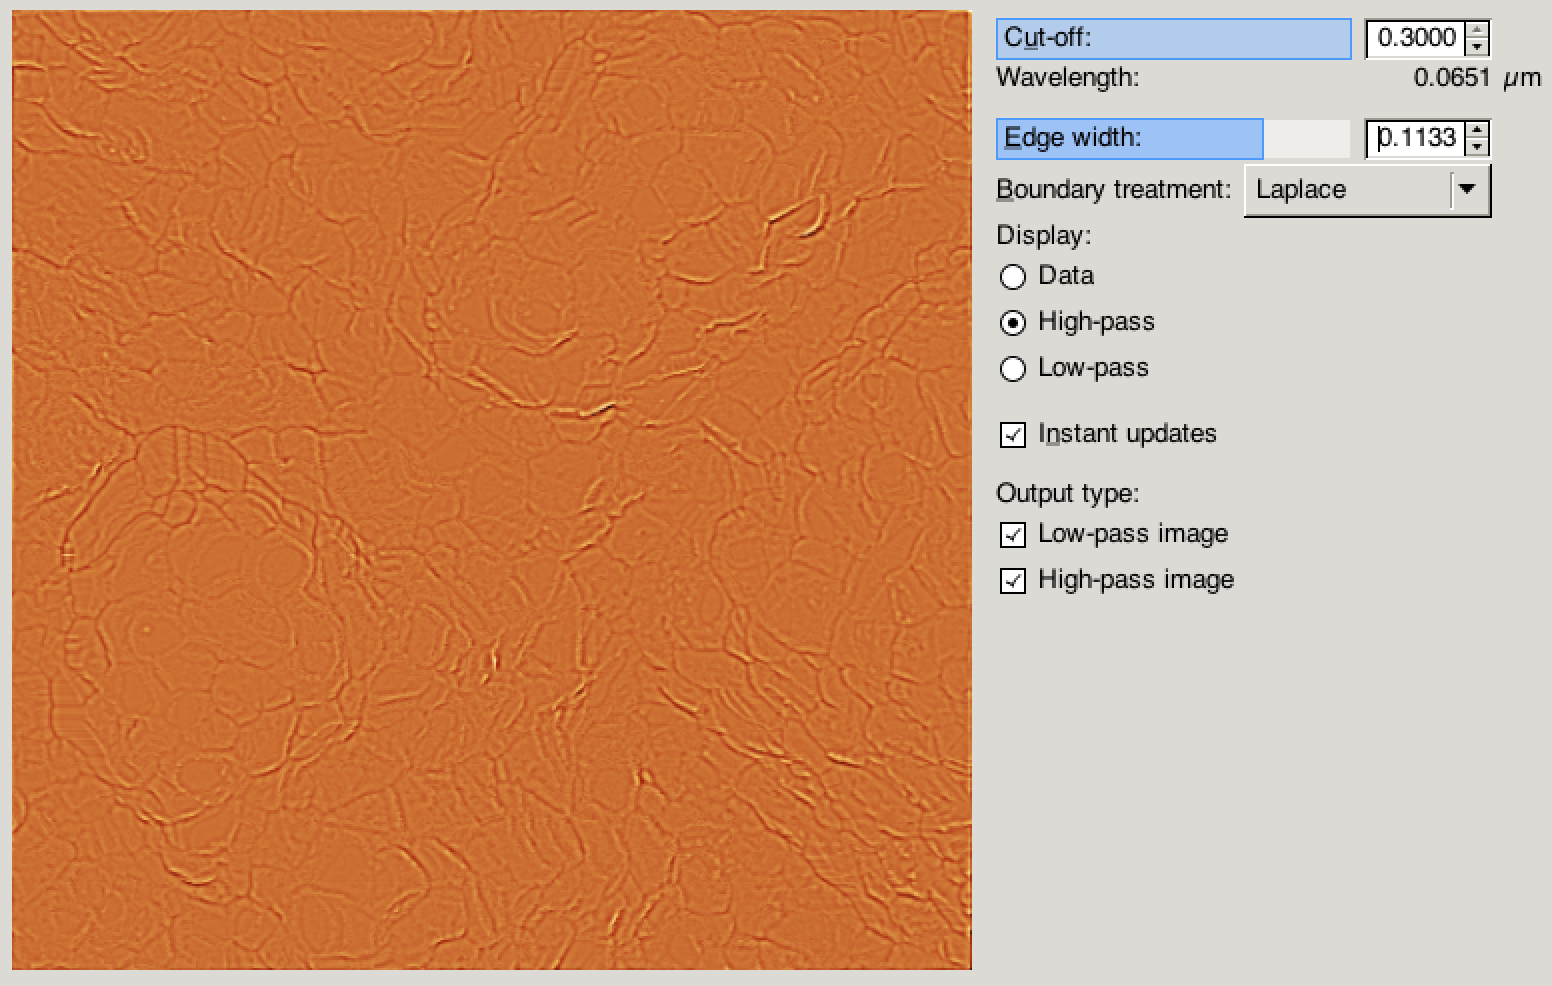

In [ ]:
def create_mask(shape: (int, int), low_pass_filter_px: float):
    rows, cols = shape
    # Create a mask to remove the low frequency content
    crow, ccol = rows // 2, cols // 2
    mask = np.ones((rows, cols, 2), np.uint8)
    # create the radius in pixels from the wavelength in nm
    radius = low_pass_filter_px
    logger.info(f"Radius: {radius}")

    mask[int(crow - radius) : int(crow + radius), int(ccol - radius) : int(ccol + radius)] = 0
    # invert the mask
    mask = 1 - mask

    return mask.astype(float)

In [ ]:
def blur_mask(mask: npt.NDArray[np.float32], sigma: float):
    mask = cv2.GaussianBlur(mask, (0, 0), sigma)
    return mask

In [ ]:
low_pass_filter_px = 50
mask_rows = 512
mask_cols = 512
mask = create_mask((mask_rows, mask_cols), low_pass_filter_px)[:, :, 0]
plt.imshow(mask, cmap="binary")
plt.title("frequency mask")
plt.show()

edge_width = 50
crow = mask_rows // 2
ccol = mask_cols // 2
# Calculate the error function for the width of the edge
erf_heights = erf(np.linspace(-3, 3, edge_width))
# Rescale to 0-1
erf_heights = erf_heights / 2 + 0.5
print(f"erf heights min: {np.min(erf_heights):.1f}, max: {np.max(erf_heights):.1f}")
erf_heights_2d = np.tile(erf_heights, (low_pass_filter_px * 2, 1)).T

plt.imshow(erf_heights_2d, cmap="binary")
plt.show()
# set the mask at the boundary to the error function
mask[
    int(crow - low_pass_filter_px - edge_width) : int(crow - low_pass_filter_px),
    int(ccol - low_pass_filter_px) : int(ccol + low_pass_filter_px),
] = erf_heights_2d

plt.imshow(mask, cmap="binary")
plt.show()

# Blur the mask
mask = blur_mask(mask, 10.0)

plt.imshow(mask, cmap="binary")
plt.show()

## Nyquist frequency
The highest frequency that can be accurately represented when sampling a signal.
It is half of the sampling rate. For image processing, the Nyquist frequency is
the highest spatial frequency that can be represented by the pixel grid of the
image and for an image of size $N \times N$, the Nyquist frequency is $N/2$.

In [ ]:
def create_high_pass_frequency_mask(shape, cutoff_wavelength_px, edge_width, mode, debug=False):
    """
    Create a high pass frequency mask for a given shape, cutoff frequency, and edge width.

    Parameters
    ----------
    shape : tuple
        The shape of the mask.
    cutoff_wavelength : float
        The cutoff wavelength in nm.
    edge_width : float
        The width of the region to smooth the mask edge by.
        Larger values will result in a smoother transition.
    mode : str
        The mode of the filter, either "high" or "low".
    debug : bool, optional
        Whether to plot & print diagnostics, by default False
    """

    # Convert the cutoff wavelength to a cutoff frequency
    cutoff_frequency = 1 / cutoff_wavelength_px

    rows, cols = shape
    crow, ccol = rows // 2, cols // 2
    u = np.arange(-ccol, ccol)
    v = np.arange(-crow, crow)
    U, V = np.meshgrid(u, v)
    # Distance from the centre for each pixel
    D = np.sqrt(U**2 + V**2)
    if debug:
        plt.imshow(D, cmap="binary")
        plt.title("Distance from centre")
        plt.colorbar()
        plt.show()

    # Normalize by Nyquist frequency
    # The nyquist frequency is calculated as the maximum
    # distance from the centre of the image, ie half the
    # diagonal of the image, hence the the hypotenuse.
    # Divide the distance grid by the hypothenuse to get
    # a normalized distance grid.
    D = D / (np.sqrt(crow**2 + ccol**2))
    if debug:
        plt.imshow(D, cmap="binary")
        plt.title("Nyquist normalised distance")
        plt.colorbar()
        plt.show()

    # This is now a normalised distance transform

    # Create mask with error function transition

    # Calculate the distance in pixels from the cutoff frequency
    # Remember that D's pixels are the distance from centre so
    # subtracting them from the cutoff gives the signed distance
    # from the cutoff frequency.
    D_signed_distance_from_cutoff = cutoff_frequency - D
    if debug:
        plt.imshow(D_signed_distance_from_cutoff, cmap="binary")
        plt.title("Signed distance from cutoff")
        plt.colorbar()
        plt.show()

    # Divide by the edge width multiplied by the cutoff frequency.
    # This ensures that the transition region is smaller when either
    # the edge width or the cutoff frequency increases, and is larger
    # when the edge width or cutoff frequency decreases. This is because
    # when the cutoff is small, we want a tighter transition inherently,
    # and when the cutoff is large, we want a larger transition inherently.

    # Decreasing the edge width will divide the distance by an increasingly
    # small number, shifting the values to be more negative, or positive
    # in relation to their position to the cutoff frequency causing them to
    # spread out more in the error function, making the transition region
    # portion of the error function a smaller proportion of the whole
    # function, and bringing it closer to the cutoff frequency in both
    # directions.
    D_normalised = D_signed_distance_from_cutoff / (edge_width)
    if debug:
        plt.imshow(D_normalised, cmap="binary")
        plt.title("Signed distance from cutoff normalised by edge width and cutoff")
        plt.colorbar()
        plt.show()

    # Re-scale the normalised distance to the range 0-1
    D_re_scaled = 0.5 * (1 + erf(D_normalised))

    if mode == "high":
        D_re_scaled = 1 - D_re_scaled
    elif mode == "low":
        pass
    else:
        raise ValueError(f"Mode {mode} not recognised")

    return D_re_scaled


# mask = create_high_pass_frequency_mask((512, 512), cutoff=0.5, edge_width=0.1)
# plt.imshow(mask, cmap="binary")
# plt.colorbar()
# plt.show()

In [ ]:
def apply_frequency_filter(image, cutoff_wavelength_px, edge_width, mode, middle_fill_px, debug=False):

    image -= np.min(image)

    original_image = image.copy()
    original_image_shape = original_image.shape
    original_image_rows = original_image_shape[0]
    original_image_cols = original_image_shape[1]

    if debug:
        sns.kdeplot(image.flatten())
        plt.title("Image heights before filtering")
        plt.show()

    # Extend the image by mirroring to avoid edge effects
    extended_image = cv2.copyMakeBorder(
        image,
        original_image_rows // 2,
        original_image_rows // 2,
        original_image_cols // 2,
        original_image_cols // 2,
        cv2.BORDER_REFLECT,
    )

    if debug:
        plt.imshow(extended_image, cmap=CMAP, vmin=VMIN, vmax=VMAX)
        plt.plot(
            [
                original_image_cols // 2,
                original_image_cols // 2,
                original_image_cols // 2 + original_image_cols,
                original_image_cols // 2 + original_image_cols,
                original_image_cols // 2,
            ],
            [
                original_image_rows // 2,
                original_image_rows // 2 + original_image_rows,
                original_image_rows // 2 + original_image_rows,
                original_image_rows // 2,
                original_image_rows // 2,
            ],
            color="white",
        )
        plt.title("Extended image")
        plt.show()

    # Compute the 2D Fourier Transform of the image
    # dft = np.fft.fft2(extended_image)
    # use opencv for the fft instead
    # dft = cv2.dft(np.float32(extended_image), flags=cv2.DFT_COMPLEX_OUTPUT)
    dft = pyfftw.interfaces.numpy_fft.fft2(extended_image)
    logger.info(f"fft shape: {dft.shape}")
    # Shift the zero frequency component to the center
    # dft_shift = np.fft.fftshift(dft)
    dft_shift = pyfftw.interfaces.numpy_fft.fftshift(dft)

    if debug:
        # Display the magnitude spectrum
        # magnitude_spectrum = 20 * np.log(cv2.magnitude(dft_shift[:, :, 0], dft_shift[:, :, 1]))
        magnitude_spectrum = 20 * np.log(np.abs(dft_shift))
        plt.imshow(magnitude_spectrum, cmap="viridis")
        plt.title("Magnitude Spectrum")
        plt.show()

    # Create the frequency mask
    mask = create_high_pass_frequency_mask(
        extended_image.shape, cutoff_wavelength_px=cutoff_wavelength_px, edge_width=edge_width, mode=mode
    )

    # Keep a section of the middle of the image
    if mode == "low":
        if middle_fill_px != -1:
            logger.warning("Low pass filter doesn't need a middle fill")
    elif mode == "high":
        if middle_fill_px == -1:
            # Just fill the very middle pixel(s)
            # If even number of pixels, fill the two middle pixels
            if extended_image.shape[0] % 2 == 0:
                mask[extended_image.shape[0] // 2, extended_image.shape[1] // 2] = 1
                mask[extended_image.shape[0] // 2 - 1, extended_image.shape[1] // 2] = 1
                mask[extended_image.shape[0] // 2, extended_image.shape[1] // 2 - 1] = 1
                mask[extended_image.shape[0] // 2 - 1, extended_image.shape[1] // 2 - 1] = 1
            else:
                mask[extended_image.shape[0] // 2, extended_image.shape[1] // 2] = 1
        elif middle_fill_px > 0:
            extended_crow, extended_ccol = extended_image.shape[0] // 2, extended_image.shape[1] // 2
            mask[
                extended_crow - middle_fill_px : extended_crow + middle_fill_px,
                extended_ccol - middle_fill_px : extended_ccol + middle_fill_px,
            ] = 1
        elif middle_fill_px == 0:
            pass
        else:
            raise ValueError(f"middle_fill_px {middle_fill_px} not recognised")

    # Apply the mask to the shifted Fourier Transform
    filtered_dft_shift = np.zeros_like(dft_shift)
    # filtered_dft_shift[:, :, 0] = dft_shift[:, :, 0] * mask
    # filtered_dft_shift[:, :, 1] = dft_shift[:, :, 1] * mask
    filtered_dft_shift = dft_shift * mask

    if debug:
        # Display the magnitude spectrum
        # magnitude_spectrum = 20 * np.log(cv2.magnitude(filtered_dft_shift[:, :, 0], filtered_dft_shift[:, :, 1]))
        magnitude_spectrum = 20 * np.log(np.abs(filtered_dft_shift))
        plt.imshow(magnitude_spectrum, cmap="viridis")
        plt.title("Filtered Magnitude Spectrum")
        plt.show()

    # Inverse shift the zero frequency component back
    # filtered_dft = np.fft.ifftshift(filtered_dft_shift)
    filtered_dft = pyfftw.interfaces.numpy_fft.ifftshift(filtered_dft_shift)

    # Compute the inverse Fourier Transform to get the filtered image
    # filtered_image = cv2.idft(filtered_dft)
    filtered_image = pyfftw.interfaces.numpy_fft.ifft2(filtered_dft)
    # filtered_image = cv2.magnitude(filtered_image[:, :, 0], filtered_image[:, :, 1])
    filtered_image = np.abs(filtered_image)

    # Normalise the image by the number of pixels
    filtered_image /= extended_image.shape[0] * extended_image.shape[1]

    if debug:
        sns.kdeplot(filtered_image.flatten())
        plt.title("Image heights after filtering")
        plt.show()

    # Crop the image back to the original size
    filtered_image = filtered_image[
        original_image_rows // 2 : -original_image_rows // 2,
        original_image_cols // 2 : -original_image_cols // 2,
    ]

    # Get the high frequency content
    subtracted = image - filtered_image

    return filtered_image, mask, subtracted


image_index = 0
filename = list(flattened_images.keys())[image_index]
image_dict = flattened_images[filename]
pixel_to_nm_scaling = image_dict["pixel_to_nm_scaling"]
logger.info(f"File: {filename}")

cutoff_wavelength_nm = 65
filtered_image, mask, subtracted = apply_frequency_filter(
    image_dict["original_image"],
    cutoff_wavelength_px=cutoff_wavelength_nm / pixel_to_nm_scaling,
    edge_width=0.10,
    mode="high",
    middle_fill_px=0,
    debug=True,
)

fig, ax = plt.subplots(1, 3, figsize=(24, 12))
ax[0].imshow(filtered_image, cmap="afmhot", vmin=0, vmax=81.8)
ax[0].set_title("Filtered image")
cbar = plt.colorbar(ax[0].imshow(filtered_image, cmap="afmhot", vmin=VMIN, vmax=VMAX), ax=ax[0])
cbar.set_label("Height (nm)")
ax[1].imshow(subtracted, cmap=CMAP, vmin=VMIN, vmax=VMAX)
ax[1].set_title("Subtracted image")
cbar = plt.colorbar(ax[1].imshow(subtracted, cmap=CMAP, vmin=VMIN, vmax=VMAX), ax=ax[1])
cbar.set_label("Height (nm)")
ax[2].imshow(mask, cmap="binary_r")
ax[2].set_title("Frequency mask")
cbar = plt.colorbar(ax[2].imshow(mask, cmap="binary_r"), ax=ax[2])
cbar.set_label("Mask value")
fig.tight_layout()
plt.show()

# plot kde of image heights
sns.kdeplot(filtered_image.flatten())
plt.title("Image heights after filtering")
plt.show()